In [1]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.1 MB/s eta 0:00:00


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [3]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(DQN, self).__init__()
        
        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        
        self.value1 = nn.Linear(32*4*4, 128)
        self.value2 = nn.Linear(128, 1)
        
        self.advantage1 = nn.Linear(32*4*4, 128)
        self.advantage2 = nn.Linear(128, num_actions)
        

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:            
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        
        value = self.relu(self.value1(x))
        value = self.value2(value)
        
        advantage = self.relu(self.advantage1(x))
        advantage = self.advantage2(advantage)
        
        q_value = value + advantage - torch.sum(advantage)/self.action_num

        return q_value

In [4]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [5]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    # TODO: your code
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

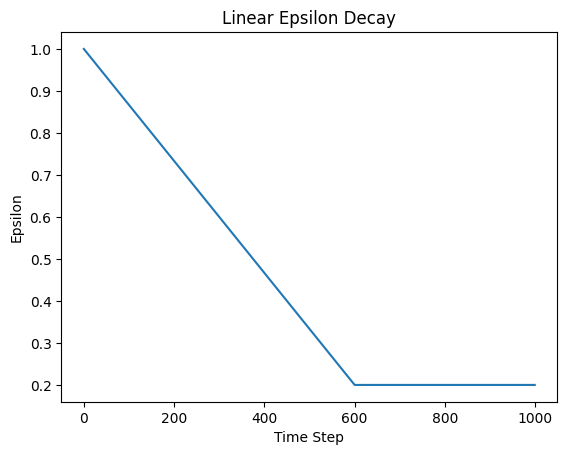

In [6]:
import matplotlib.pyplot as plt

eps_start = 1.0
eps_end = 0.2
schedule_duration = 1000

eps_values = [linear_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()


In [7]:
test_input = torch.tensor([1, 2, 3, 4], dtype=torch.float32)

# Given a neural network
net = nn.Sequential(
    nn.Linear(4, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)
print(f"Prediction (Before): {net(test_input)}\n")

# We can get its parameters with .state_dict(). A dictionary containing all the parameters.
# Note: It contains even more than parameters, but that is not relevant for us.
params = copy.deepcopy(net.state_dict())

print("Parameters:")
for key, value in params.items():
    print(f"- Parameter {key}:\n{value}")

# Set weight matrix of first layer to zero
net[0].weight.data.fill_(0.0)
print(f"\nPrediction (After change): {net(test_input)}\n")

# Load the old parameters
net.load_state_dict(params)
print(f"Prediction (After reload): {net(test_input)}\n")


Prediction (Before): tensor([0.3378], grad_fn=<ViewBackward0>)

Parameters:
- Parameter 0.weight:
tensor([[ 0.2979, -0.3048,  0.4008, -0.1396],
        [-0.2257,  0.3717, -0.1529,  0.3255],
        [-0.1536, -0.1828,  0.0299,  0.4027]])
- Parameter 0.bias:
tensor([-0.3722,  0.3472, -0.1570])
- Parameter 2.weight:
tensor([[-0.2335,  0.4930, -0.2098]])
- Parameter 2.bias:
tensor([-0.2893])

Prediction (After change): tensor([-0.1182], grad_fn=<ViewBackward0>)

Prediction (After reload): tensor([0.3378], grad_fn=<ViewBackward0>)



In [8]:
class PrioritizedReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.priorities = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        # TODO: Your code
        return len(self.data)

    def get_probabilities(self, priority_scale):
        #print(f"get_probabilities: self.priorities & type(self.priorities), len(self.priorities) = ", self.priorities, type(self.priorities),  type(self.priorities[0]), len(self.priorities))
        scaled_priorities = torch.tensor(self.priorities) ** priority_scale #np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities/sum(scaled_priorities)
        #print(f"get_probabilities: priority_scale={priority_scale}, scaled_priorities={scaled_priorities}, sum(scaled_priorities)={sum(scaled_priorities)} ")
        return sample_probabilities

    def set_priorities(self, indices, errors, offset=0.1):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset
            #print(f"set_priority idx: i={i}; e={e}; type(e)={type(e)}; type(offset)={type(offset)}; abs(e)={abs(e)}; (abs(e) + offset)={(abs(e) + offset)} ")

        #print(f"self.priorities: priorities, len of data buffer, len of priority buffer=",self.priorities, len(self.data), len(self.priorities))

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        # TODO: Your code
        data = (obs, action, reward, next_obs, terminated)
        if len(self.data) < self.max_size:
            self.data.append(data)
            self.priorities.append(max(self.priorities, default=1)) #Setting initial priorities
            #print(f"store_0 priority append priority={max(self.priorities, default=1)}")
        else:
            self.position = self.position % self.max_size
            self.data[self.position] = data
            self.priorities[self.position] = max(self.priorities, default=1) #Setting initial priorities
            #print(f"store_1 priority append to position = {self.position}; priority={max(self.priorities, default=1)}")
        self.position = self.position + 1

    def sample(self, batch_size: int, priority_scale=1.0) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        # TODO: Your code
        sample_size = min(len(self.data), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.data)), k=batch_size, weights=sample_probs)
        #print(f"sample_indices = ",sample_indices)
        #print(f"self.priorities = ", self.priorities)
        #samples=np.array(self.data)[sample_indices]

        """
        obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch = [], [], [], [], []
        for i in range(len(sample_indices)):
            idx = sample_indices[i]
            data = self.data[idx]
            obs, action, reward, next_obs, flag = data
            obs_batch.append(obs)
            action_batch.append(action)
            reward_batch.append(reward)
            next_obs_batch.append(next_obs)
            terminated_batch.append(flag)

        # Convert the individual lists to numpy first before converting to tensor, to avoid DeprecationWarning
        obs_batch = np.array(obs_batch)
        action_batch = np.array(action_batch)
        reward_batch = np.array(reward_batch)
        next_obs_batch = np.array(next_obs_batch)
        terminated_batch = np.array(terminated_batch)

        #print(f"Numpy obs_batch=", obs_batch)
        #print(f"Numpy action_batch=", action_batch)
        #print(f"Numpy reward_batch=", reward_batch)
        #print(f"Numpy next_obs_batch=", next_obs_batch)
        #print(f"Numpy terminated_batch=", terminated_batch)

        print(f"Numpy obs_batch=", type(obs_batch), type(obs_batch[0]))
        print(f"Numpy action_batch=", type(action_batch), type(action_batch[0]))
        print(f"Numpy reward_batch=", type(reward_batch), type(reward_batch[0]))
        print(f"Numpy next_obs_batch=", type(next_obs_batch), type(next_obs_batch[0]))
        print(f"Numpy terminated_batch=", type(terminated_batch), type(terminated_batch[0]))

        obs_batch = torch.from_numpy(obs_batch).to(dtype=torch.float32)
        action_batch = torch.from_numpy(action_batch).to(dtype=torch.float32)
        reward_batch = torch.from_numpy(reward_batch).to(dtype=torch.float32)
        next_obs_batch = torch.from_numpy(next_obs_batch).to(dtype=torch.float32)
        terminated_batch = torch.from_numpy(terminated_batch).to(dtype=torch.float32)
        """

        selected_samples = [self.data[i] for i in sample_indices]
        output = [torch.stack(b) for b in zip(*selected_samples)]
        #output =  [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size, weights=sample_probs))]
        return output, sample_indices

In [9]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()
    #print(f"Inside update_dqn")
    # TODO: Calculate the TD-Target
    with torch.no_grad():
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())
    #print(f"update_dqn: td_target = ", td_target)
    q_val = q(obs).gather(1, act.unsqueeze(1))
    #print(f"update_dqn: q_val = ", q_val)
    # TODO: Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    loss = F.mse_loss(q_val, td_target.unsqueeze(1)) #Assuming errors for individual samples in loss
    #print(f"update_dqn: Loss = ", loss)
    # TODO: Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()

    error_batch =  torch.sub(q_val, td_target.unsqueeze(1))
    #print(f"update_dqn: error_batch = ", error_batch)
    error_batch = error_batch.detach()
    #print(f"update_dqn: error_batch length to verify with batch_size=", len(error_batch.detach()))
    #print(f"update_dqn: Detached error values=", error_batch.detach())

    return error_batch


In [10]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.priority_scale = 1.0
        self.error_to_set_priority = 0.0

        # TODO: Initialize the Prioritized Replay Buffer
        self.buffer = PrioritizedReplayBuffer(maxlen)

        # TODO: Initialize the Deep Q Network. Hint: Remember observation_space and action_space
        self.q = DQN(env.observation_space.shape, env.action_space.n)

        # TODO: Initialize the second Q Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        # TODO: Create an ADAM optimizer for the Q network
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                #print(f"\n\n LOOP episode_time={episode_time}")

                #print(f"A-Get Current Epsilon Value")
                # TODO: Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                #print(f"B-Choose action and execute")
                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                #print(f"C-Buffer Store")
                # TODO: Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(int(terminated))
                )

                #print(f"D-Buffer Sample")
                # TODO: Sample a mini batch from the replay buffer
                data, sample_indices = self.buffer.sample(self.batch_size, self.priority_scale)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = data
                #print(f"1 rew_batch =  ", rew_batch)
                #print(f"1 act_batch =  ", act_batch)
                #print(f"1 tm_batch =  ", tm_batch)

                #print(f"E-Update DQN")
                # Update the Q network
                batch_errors = update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                #print(f"F-Set Prioroties in replay buffer")
                #print(f"2 done, batch_errors = ", batch_errors)
                #print(f"2 sample_indices passed to set priority = ", sample_indices)
                self.buffer.set_priorities(sample_indices, batch_errors)
                #print(f"3 done")
                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                #print(f"G-Set next_obs to obs to continue further")
                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [14]:
# Choose your environment
#env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")
# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 300 #1000
DISCOUNT_FACTOR = 0.99

# Train DQN
agent = DQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)

Episode 100 of 300  Time Step: 7423  Epsilon: 0.277
Episode 200 of 300  Time Step: 23873  Epsilon: 0.050
Episode 300 of 300  Time Step: 43738  Epsilon: 0.050


# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

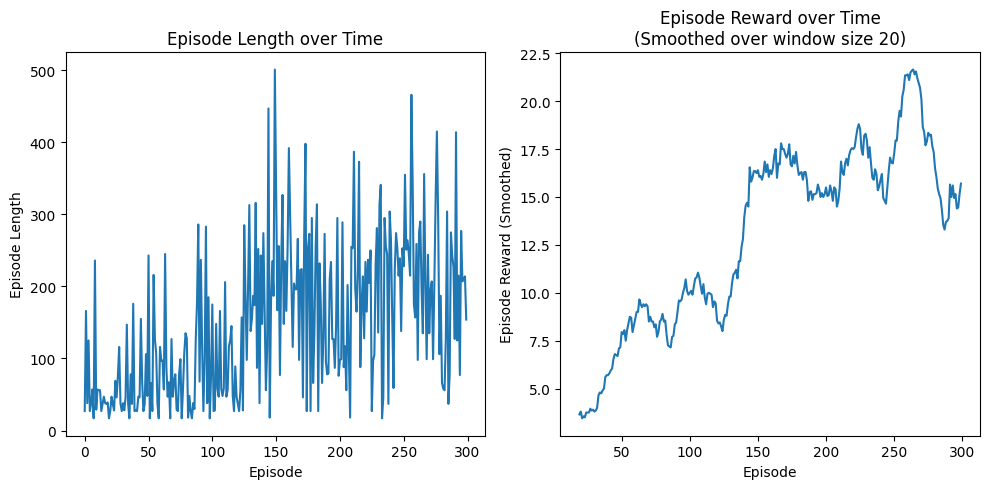

In [15]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

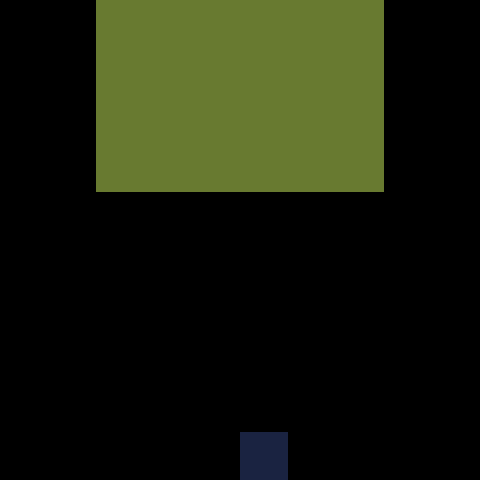

In [16]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")